<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-kamilla-jaroslav/blob/main/cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%%capture
!pip install torch torchvision matplotlib pytorch_ssim





In [18]:
import zipfile

# Укажите имя файла с расширением .zip
zip_file = "/content/processed_images (2).zip"  # Замените на имя вашего файла

# Укажите папку для распаковки
output_folder = "/processed_images (2)"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print(f"Данные распакованы в папку: {output_folder}")

Данные распакованы в папку: /processed_images (2)


In [ ]:
import os

# Проверка содержимого распакованной папки
os.listdir(output_folder)

['processed_experiment_images', 'processed_simulation_images']

Weights saved for epoch 0
Epoch [1/100], Generator Loss: 5.01481819152832, Discriminator Loss: 0.0051571158692240715


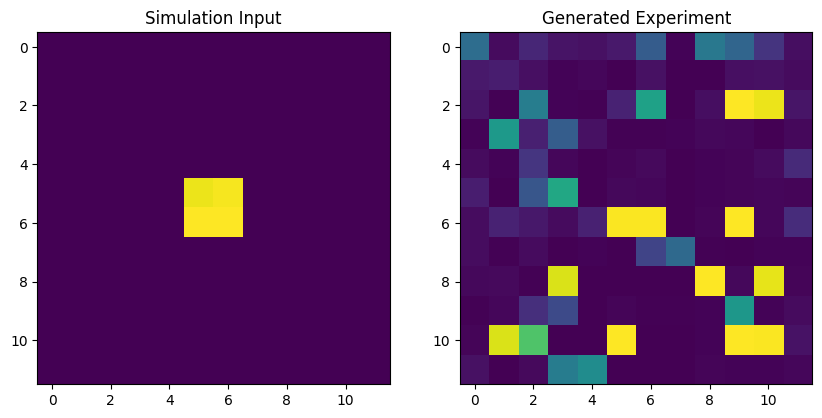

Weights saved for epoch 1
Epoch [2/100], Generator Loss: 3.7431840896606445, Discriminator Loss: 0.0029950779862701893
Weights saved for epoch 2
Epoch [3/100], Generator Loss: 3.7009150981903076, Discriminator Loss: 0.0041137393563985825
Weights saved for epoch 3
Epoch [4/100], Generator Loss: 3.348906993865967, Discriminator Loss: 0.0016081505455076694
Weights saved for epoch 4
Epoch [5/100], Generator Loss: 3.329343557357788, Discriminator Loss: 0.004144747741520405
Weights saved for epoch 5
Epoch [6/100], Generator Loss: 3.135592460632324, Discriminator Loss: 0.00030419646645896137
Weights saved for epoch 6
Epoch [7/100], Generator Loss: 2.9325175285339355, Discriminator Loss: 0.001024249941110611
Weights saved for epoch 7
Epoch [8/100], Generator Loss: 3.0938351154327393, Discriminator Loss: 0.0013978531351312995
Weights saved for epoch 8
Epoch [9/100], Generator Loss: 3.0143117904663086, Discriminator Loss: 0.00045092686195857823
Weights saved for epoch 9
Epoch [10/100], Generator

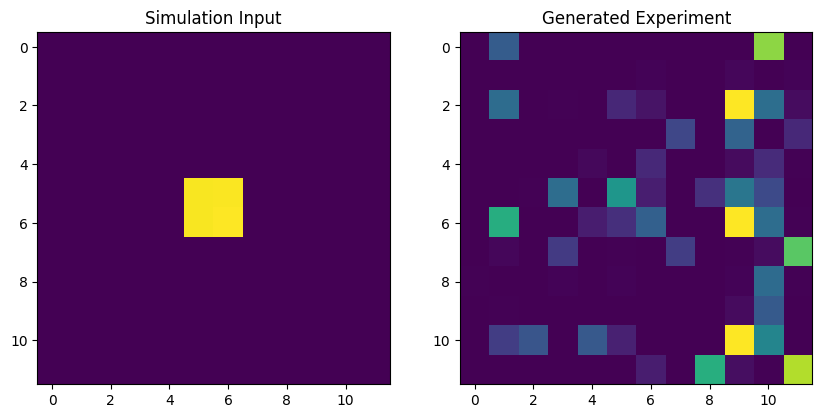

Weights saved for epoch 11
Epoch [12/100], Generator Loss: 3.1227340698242188, Discriminator Loss: 0.0026642181910574436
Weights saved for epoch 12
Epoch [13/100], Generator Loss: 2.7222511768341064, Discriminator Loss: 0.00011131435167044401
Weights saved for epoch 13
Epoch [14/100], Generator Loss: 2.819916009902954, Discriminator Loss: 0.0009180093184113503
Weights saved for epoch 14
Epoch [15/100], Generator Loss: 2.6946046352386475, Discriminator Loss: 0.0002760407514870167
Weights saved for epoch 15
Epoch [16/100], Generator Loss: 2.733492374420166, Discriminator Loss: 0.0009252649615518749
Weights saved for epoch 16
Epoch [17/100], Generator Loss: 2.7351632118225098, Discriminator Loss: 0.00031514791771769524
Weights saved for epoch 17
Epoch [18/100], Generator Loss: 2.6562137603759766, Discriminator Loss: 0.00033998177968896925
Weights saved for epoch 18
Epoch [19/100], Generator Loss: 2.4504852294921875, Discriminator Loss: 0.00023427944688592106
Weights saved for epoch 19
Epo

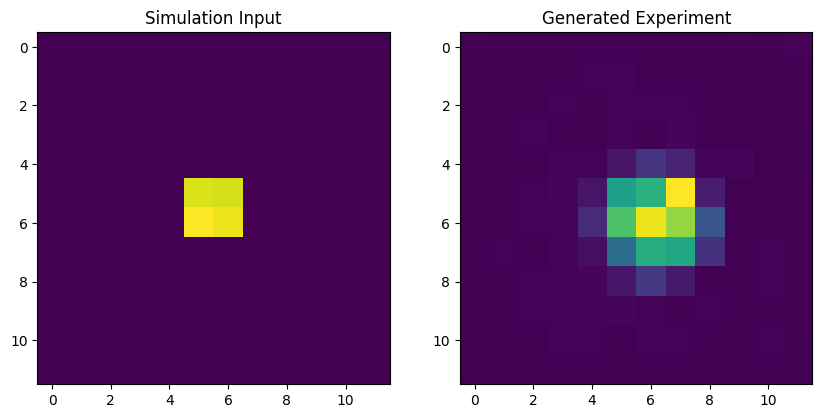

Weights saved for epoch 21
Epoch [22/100], Generator Loss: 0.651520848274231, Discriminator Loss: 0.24757657945156097
Weights saved for epoch 22
Epoch [23/100], Generator Loss: 0.6359667181968689, Discriminator Loss: 0.2502349317073822
Weights saved for epoch 23
Epoch [24/100], Generator Loss: 0.6316407322883606, Discriminator Loss: 0.2515771985054016
Weights saved for epoch 24
Epoch [25/100], Generator Loss: 0.6571792960166931, Discriminator Loss: 0.2490389347076416
Weights saved for epoch 25
Epoch [26/100], Generator Loss: 0.6882442235946655, Discriminator Loss: 0.24684303998947144
Weights saved for epoch 26
Epoch [27/100], Generator Loss: 0.6438800692558289, Discriminator Loss: 0.24671730399131775
Weights saved for epoch 27
Epoch [28/100], Generator Loss: 0.6479969024658203, Discriminator Loss: 0.25174805521965027
Weights saved for epoch 28
Epoch [29/100], Generator Loss: 0.4654344916343689, Discriminator Loss: 0.25083819031715393
Weights saved for epoch 29
Epoch [30/100], Generator

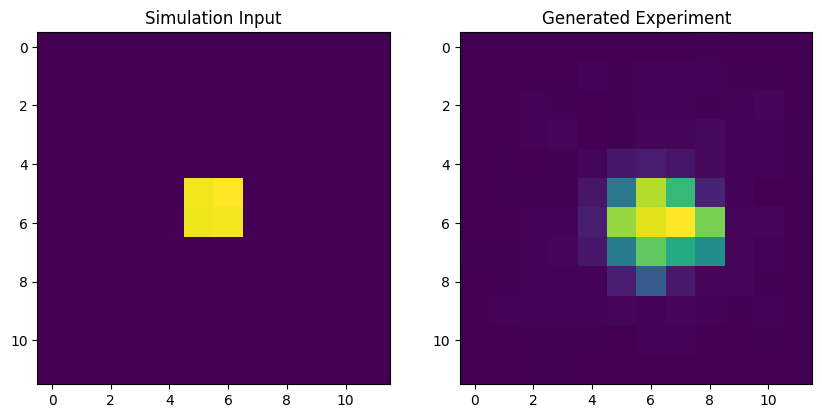

Weights saved for epoch 31
Epoch [32/100], Generator Loss: 0.6847061514854431, Discriminator Loss: 0.2570679485797882
Weights saved for epoch 32
Epoch [33/100], Generator Loss: 0.87960284948349, Discriminator Loss: 0.2394496202468872
Weights saved for epoch 33
Epoch [34/100], Generator Loss: 0.7565031051635742, Discriminator Loss: 0.24232569336891174
Weights saved for epoch 34
Epoch [35/100], Generator Loss: 0.6324079036712646, Discriminator Loss: 0.23736223578453064
Weights saved for epoch 35
Epoch [36/100], Generator Loss: 0.6496131420135498, Discriminator Loss: 0.23738959431648254
Weights saved for epoch 36
Epoch [37/100], Generator Loss: 0.8465981483459473, Discriminator Loss: 0.2831597328186035
Weights saved for epoch 37
Epoch [38/100], Generator Loss: 0.7660226225852966, Discriminator Loss: 0.24199868738651276
Weights saved for epoch 38
Epoch [39/100], Generator Loss: 0.7866336703300476, Discriminator Loss: 0.2249869704246521
Weights saved for epoch 39
Epoch [40/100], Generator L

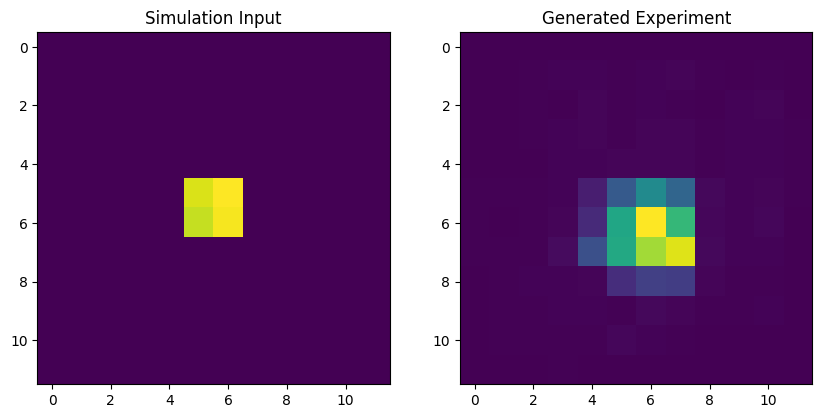

Weights saved for epoch 41
Epoch [42/100], Generator Loss: 0.790428102016449, Discriminator Loss: 0.20692124962806702
Weights saved for epoch 42
Epoch [43/100], Generator Loss: 0.8838979005813599, Discriminator Loss: 0.18843814730644226
Weights saved for epoch 43
Epoch [44/100], Generator Loss: 0.6355247497558594, Discriminator Loss: 0.22838401794433594
Weights saved for epoch 44
Epoch [45/100], Generator Loss: 0.729764997959137, Discriminator Loss: 0.21362482011318207
Weights saved for epoch 45
Epoch [46/100], Generator Loss: 0.6893089413642883, Discriminator Loss: 0.24201563000679016
Weights saved for epoch 46
Epoch [47/100], Generator Loss: 0.7373731136322021, Discriminator Loss: 0.23337909579277039
Weights saved for epoch 47
Epoch [48/100], Generator Loss: 0.740932822227478, Discriminator Loss: 0.17775078117847443
Weights saved for epoch 48
Epoch [49/100], Generator Loss: 0.8570702075958252, Discriminator Loss: 0.22129258513450623
Weights saved for epoch 49
Epoch [50/100], Generato

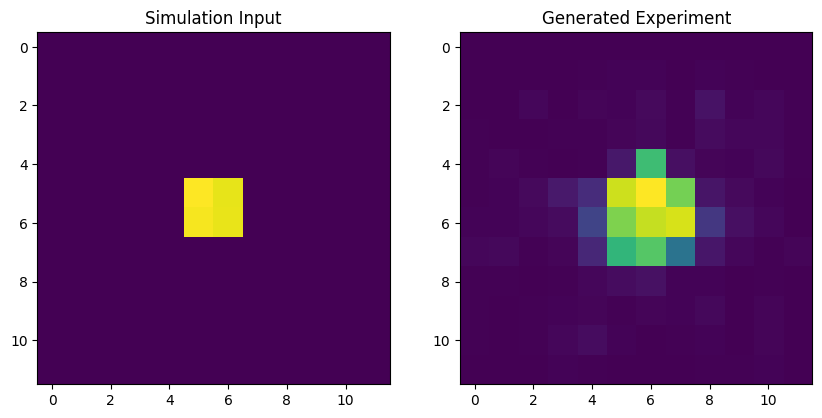

Weights saved for epoch 51
Epoch [52/100], Generator Loss: 0.7854522466659546, Discriminator Loss: 0.1989464908838272
Weights saved for epoch 52
Epoch [53/100], Generator Loss: 0.47859132289886475, Discriminator Loss: 0.24898037314414978
Weights saved for epoch 53
Epoch [54/100], Generator Loss: 1.421539306640625, Discriminator Loss: 0.17866748571395874
Weights saved for epoch 54
Epoch [55/100], Generator Loss: 0.8695501685142517, Discriminator Loss: 0.17862263321876526
Weights saved for epoch 55
Epoch [56/100], Generator Loss: 0.5974138975143433, Discriminator Loss: 0.24645671248435974
Weights saved for epoch 56
Epoch [57/100], Generator Loss: 0.9711675643920898, Discriminator Loss: 0.21221309900283813
Weights saved for epoch 57
Epoch [58/100], Generator Loss: 0.8776295185089111, Discriminator Loss: 0.18874859809875488
Weights saved for epoch 58
Epoch [59/100], Generator Loss: 0.6415391564369202, Discriminator Loss: 0.2075580656528473
Weights saved for epoch 59
Epoch [60/100], Generat

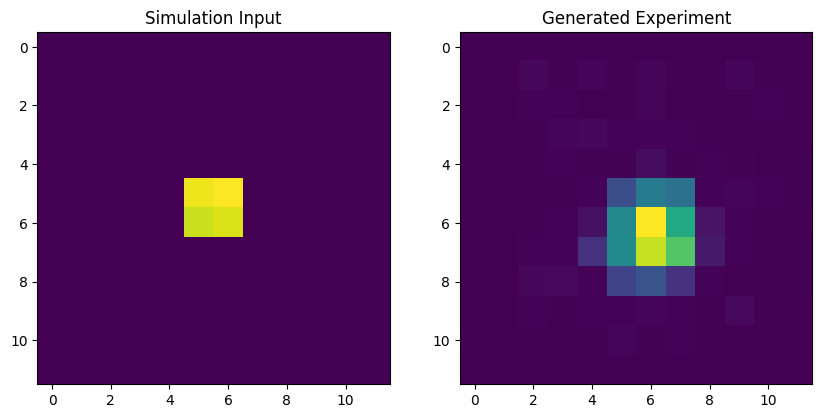

Weights saved for epoch 61
Epoch [62/100], Generator Loss: 0.6498268842697144, Discriminator Loss: 0.21210269629955292
Weights saved for epoch 62
Epoch [63/100], Generator Loss: 0.9360220432281494, Discriminator Loss: 0.18939189612865448
Weights saved for epoch 63
Epoch [64/100], Generator Loss: 0.7109631299972534, Discriminator Loss: 0.20231005549430847
Weights saved for epoch 64
Epoch [65/100], Generator Loss: 1.0377631187438965, Discriminator Loss: 0.21094036102294922
Weights saved for epoch 65
Epoch [66/100], Generator Loss: 0.5434860587120056, Discriminator Loss: 0.2212420403957367
Weights saved for epoch 66
Epoch [67/100], Generator Loss: 0.9918684363365173, Discriminator Loss: 0.2646883428096771
Weights saved for epoch 67
Epoch [68/100], Generator Loss: 0.6182358860969543, Discriminator Loss: 0.21432258188724518
Weights saved for epoch 68
Epoch [69/100], Generator Loss: 0.8148181438446045, Discriminator Loss: 0.24334070086479187
Weights saved for epoch 69
Epoch [70/100], Generat

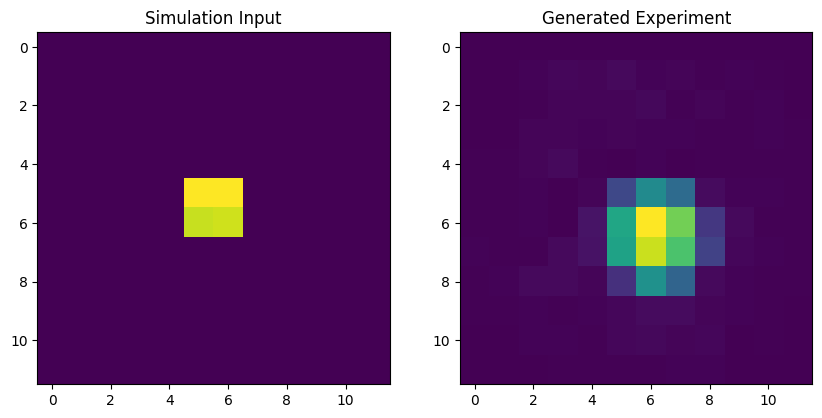

Weights saved for epoch 71
Epoch [72/100], Generator Loss: 0.5632789134979248, Discriminator Loss: 0.24328818917274475
Weights saved for epoch 72
Epoch [73/100], Generator Loss: 0.6458203792572021, Discriminator Loss: 0.23489804565906525
Weights saved for epoch 73
Epoch [74/100], Generator Loss: 0.7324163913726807, Discriminator Loss: 0.22558008134365082
Weights saved for epoch 74
Epoch [75/100], Generator Loss: 0.7739377021789551, Discriminator Loss: 0.23001912236213684
Weights saved for epoch 75
Epoch [76/100], Generator Loss: 0.6862161159515381, Discriminator Loss: 0.23987504839897156
Weights saved for epoch 76
Epoch [77/100], Generator Loss: 0.6184015870094299, Discriminator Loss: 0.2507646083831787
Weights saved for epoch 77
Epoch [78/100], Generator Loss: 0.6412821412086487, Discriminator Loss: 0.24860058724880219
Weights saved for epoch 78
Epoch [79/100], Generator Loss: 0.617507815361023, Discriminator Loss: 0.23682285845279694
Weights saved for epoch 79
Epoch [80/100], Generat

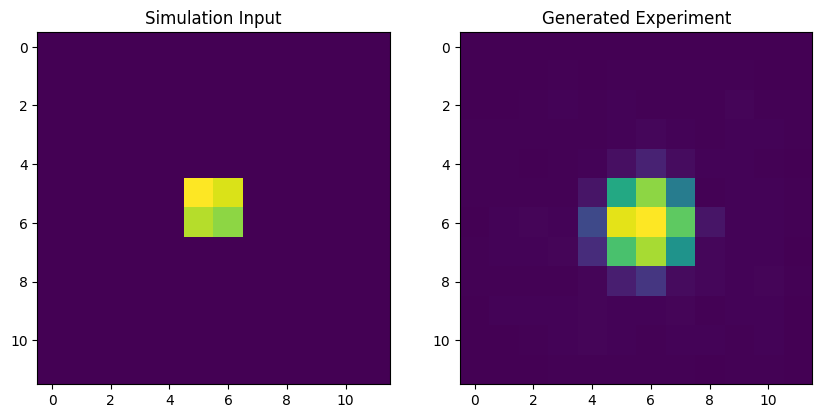

Weights saved for epoch 81
Epoch [82/100], Generator Loss: 0.5936287045478821, Discriminator Loss: 0.2884979248046875
Weights saved for epoch 82
Epoch [83/100], Generator Loss: 0.5515344142913818, Discriminator Loss: 0.26425662636756897
Weights saved for epoch 83
Epoch [84/100], Generator Loss: 0.586360514163971, Discriminator Loss: 0.24843856692314148
Weights saved for epoch 84
Epoch [85/100], Generator Loss: 0.5195715427398682, Discriminator Loss: 0.2664014995098114
Weights saved for epoch 85
Epoch [86/100], Generator Loss: 0.5909572243690491, Discriminator Loss: 0.2603721618652344
Weights saved for epoch 86
Epoch [87/100], Generator Loss: 0.8361018300056458, Discriminator Loss: 0.21876946091651917
Weights saved for epoch 87
Epoch [88/100], Generator Loss: 0.6133880019187927, Discriminator Loss: 0.24100489914417267
Weights saved for epoch 88
Epoch [89/100], Generator Loss: 0.6855198740959167, Discriminator Loss: 0.23753559589385986
Weights saved for epoch 89
Epoch [90/100], Generator

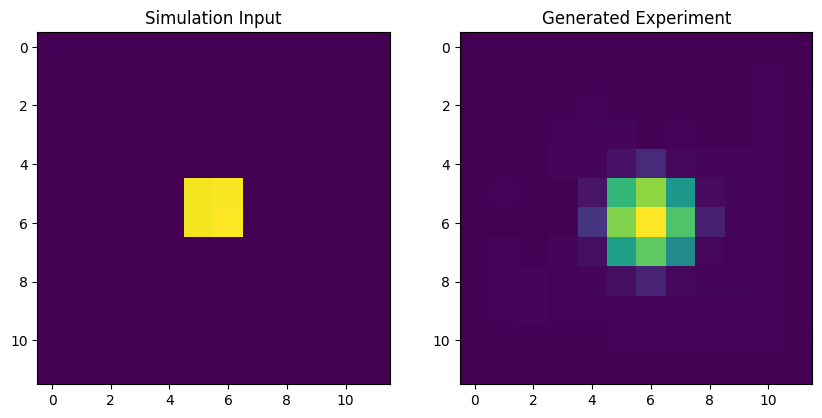

Weights saved for epoch 91
Epoch [92/100], Generator Loss: 0.5715169310569763, Discriminator Loss: 0.2438284158706665
Weights saved for epoch 92
Epoch [93/100], Generator Loss: 0.7496947050094604, Discriminator Loss: 0.2292102426290512
Weights saved for epoch 93
Epoch [94/100], Generator Loss: 0.6991049647331238, Discriminator Loss: 0.22230051457881927
Weights saved for epoch 94
Epoch [95/100], Generator Loss: 0.7082488536834717, Discriminator Loss: 0.19865009188652039
Weights saved for epoch 95
Epoch [96/100], Generator Loss: 1.0049105882644653, Discriminator Loss: 0.1988222599029541
Weights saved for epoch 96
Epoch [97/100], Generator Loss: 0.5750628709793091, Discriminator Loss: 0.2448054552078247
Weights saved for epoch 97
Epoch [98/100], Generator Loss: 0.5921272039413452, Discriminator Loss: 0.25035494565963745
Weights saved for epoch 98
Epoch [99/100], Generator Loss: 0.6058552861213684, Discriminator Loss: 0.23562808334827423
Weights saved for epoch 99
Epoch [100/100], Generato

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
from tqdm import tqdm
from pytorch_ssim import SSIM


# Утилита для загрузки данных
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        image = (image - 0.5) * 2
        image = np.expand_dims(image, axis=0).astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image)

# Параметры загрузки данных
simulation_dir = "/processed_images (2)/processed_images/processed_simulation_images_12"
experiment_dir = "/processed_images (2)/processed_images/processed_experiment_images_12"

# Загрузка данных
sim_dataset = ImageDataset(simulation_dir)
exp_dataset = ImageDataset(experiment_dir)

sim_dataloader = DataLoader(sim_dataset, batch_size=16, shuffle=True)
exp_dataloader = DataLoader(exp_dataset, batch_size=16, shuffle=True)

# Модель генератора с U-Net архитектурой
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Модель дискриминатора
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # padding целое число
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1)  # padding целое число
        )

    def forward(self, x):
        return self.model(x)



# Инициализация моделей
gen = Generator().cuda()  # Инициализация генератора
disc = Discriminator().cuda()  # Инициализация дискриминатора

def cycle_loss(real, reconstructed):
    # Приводим размеры изображений к одинаковым
    if real.size() != reconstructed.size():
        reconstructed = F.interpolate(reconstructed, size=real.size()[2:], mode='bilinear', align_corners=False)

    return torch.mean(torch.abs(real - reconstructed))

# Оптимизаторы
gen_optimizer = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
# Обучение
epochs = 100
for epoch in range(epochs):
    torch.save(gen.state_dict(), f"{checkpoint_dir}/generator_epoch_{epoch}.pth")
    torch.save(disc.state_dict(), f"{checkpoint_dir}/discriminator_epoch_{epoch}.pth")
    print(f"Weights saved for epoch {epoch}")
    for sim_images, exp_images in zip(sim_dataloader, exp_dataloader):
        sim_images, exp_images = sim_images.cuda(), exp_images.cuda()

        # Генерация
        fake_exp = gen(sim_images)
        fake_sim = gen(exp_images)

        # Обучение дискриминаторов
        disc_optimizer.zero_grad()
        real_loss_exp = torch.mean((disc(exp_images) - 1) ** 2)
        fake_loss_exp = torch.mean(disc(fake_exp) ** 2)
        disc_loss_exp = (real_loss_exp + fake_loss_exp) / 2

        real_loss_sim = torch.mean((disc(sim_images) - 1) ** 2)
        fake_loss_sim = torch.mean(disc(fake_sim) ** 2)
        disc_loss_sim = (real_loss_sim + fake_loss_sim) / 2

        disc_loss = (disc_loss_exp + disc_loss_sim) / 2
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # Обучение генераторов
        gen_optimizer.zero_grad()
        gen_loss_exp = torch.mean((disc(fake_exp) - 1) ** 2)
        gen_loss_sim = torch.mean((disc(fake_sim) - 1) ** 2)

        cycle_loss_exp = cycle_loss(exp_images, gen(fake_sim))
        cycle_loss_sim = cycle_loss(sim_images, gen(fake_exp))

        gen_loss = gen_loss_exp + gen_loss_sim + 10 * (cycle_loss_exp + cycle_loss_sim)
        gen_loss.backward()
        gen_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {gen_loss.item()}, Discriminator Loss: {disc_loss.item()}")

    # Визуализация результатов каждые 10 эпох
    if epoch % 10 == 0:
        with torch.no_grad():
            example_sim = sim_images[0:1]
            example_generated = gen(example_sim)[0]
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Simulation Input")
            plt.imshow(example_sim[0].cpu().numpy().squeeze(), cmap="viridis")
            plt.subplot(1, 2, 2)
            plt.title("Generated Experiment")
            plt.imshow(example_generated.cpu().numpy().squeeze(), cmap="viridis")
            plt.show()


In [27]:
gen.load_state_dict(torch.load("checkpoints/generator_epoch_21.pth", weights_only=True))
disc.load_state_dict(torch.load("checkpoints/discriminator_epoch_21.pth", weights_only=True))
print("Weights for epoch 21 loaded")

Weights for epoch 21 loaded
